# 3. Ground-truth retina (Stage 1b: Retinal mosaic)

This Jupyter notebook demonstrates how to generate a ground-truth retina that uses the output of the reaction-diffusion modelling for the starting mosaic. The output is a retinal parameter array, which we will save to a FITS file to be used later for image generation. In this notebook we are working with a large example mosaic (up to 10 degrees eccentricity) and so some of the functions may take a little time to run.

In this notebook we will run through the steps to generate the retinal parameter array to demonstrate how this works. However, in practice, the generate_retina module has a wrapper function that does these steps for you - see Section 3.5.

First we import the relevant modules:

In [1]:
# Set matplotlib up
%matplotlib inline

import numpy
import os
import sys
import yaml

from matplotlib import pyplot
from astropy.io import fits
from PIL import Image

from ERICA import generate_retina, AOSLO_system, sampling, peak_detection, frame_generation, ERICA_toolkit

current_directory = os.getcwd()

For generating cone reflectance distributions, we use the distribution parameters (<span style='background-color:rgb(199,235,236)'>cone reflectance parameters</span>) saved to file (<span style='background-color:rgb(199,235,236)'>cone_reflectance_parameters.yaml</span>). You could write your own version of this file to match the distribution of cone reflectances measured via your own system, if you wish.

In [41]:
# Specify the parameter file to use
cone_reflectance_parameters_file = os.path.normpath(os.path.join(current_directory, 'Reflectance_parameters', 'cone_reflectance_parameters.yaml'))
sys.stdout.write('Using parameter file: %s\n'%cone_reflectance_parameters_file)
# Open the cone reflectance parameters file
with open(cone_reflectance_parameters_file, 'r') as f:
    cone_reflectance_parameters = yaml.safe_load(f)


Using parameter file: /Users/laurayoung/Documents/Repositories/erica_final/Reflectance_parameters/cone_reflectance_parameters.yaml


Below is a plotting function that we will use later to inspect the data that is generated:

In [42]:
def plotSpacing(mapped, microns_per_degree, fnum=1, n_neighbours=3):
    
    # Detect the spacings between each cone and its nearest neighbours
    spacing = generate_retina.determineSpacing(numpy.transpose(mapped), n_neighbours=n_neighbours)
   
    # Calculate the eccentricities (in microns) of each cone cell
    eccentricies_points_um = numpy.sqrt(mapped[1]**2+mapped[0]**2)

    # Calculate the expected cone spacings based on Curcio et al. (1990) data
    radial = numpy.linspace(0,10,20)
    y = numpy.zeros(radial.shape)
    eccentricities_compare = numpy.array([y,radial])
    spacing_compare = generate_retina.spacingFromEccentricity(eccentricities_compare)

    # Plot the expected cone spacings in black and show the spacings of the generated mosaic of cones in blue
    fig_1 = pyplot.figure(fnum, figsize=(10,4))
    ax1_1 = fig_1.add_subplot(111)
    ax1_1.scatter(eccentricies_points_um/microns_per_degree, spacing, s=2, color='b', label='Generated mosaic')
    ax1_1.plot(radial,spacing_compare, color='black', label='Curcio et al. 1990 fit')
    ax1_1.scatter(generate_retina.CONE_POSITIONS,generate_retina.CONE_SPACING_UM, color='black', label='Curcio et al. 1990 data', s=6)
    
    ax1_1.set_xlim(0,radial.max())
    ax1_1.set_xlabel('Eccentricity (degrees)')
    ax1_1.set_ylabel('Cone spacing (microns)')
    pyplot.legend(loc='upper left', bbox_to_anchor=(1,1))
    return fig_1, ax1_1

## 3.1 Set up your AOSLO
As described in notebook "1. Setting up your AOSLO", first we need to create an instance of an AOSLO object based on the <span style='background-color:rgb(206,190,218)'>system parameter file</span>. This allows us to access information about the AOSLO and its imaging parameters, such as the imaging wavelength, sampling resolution etc.


In [43]:
# Specify the AOSLO system parameter file to use
system_parameters_file = 'system_parameters_demo.yaml'
sys.stdout.write('Using parameter file: %s'%system_parameters_file)

# Create the AOSLO instance
myAOSLO = AOSLO_system.AOSLO(os.path.normpath(os.path.join(current_directory, 'System_parameters', system_parameters_file)))


Using parameter file: system_parameters_demo.yaml

Then we set where the retina parameter array will be stored:

In [44]:
save_folder_ground_truth = os.path.normpath(os.path.join(current_directory, 'Retinal_mosaic_parameters_arrays', system_parameters_file.split('.')[0]))

if os.path.isdir(os.path.normpath(os.path.join(current_directory, 'Retinal_mosaic_parameters_arrays'))) == 0:
    os.mkdir(os.path.normpath(os.path.join(current_directory, 'Retinal_mosaic_parameters_arrays')))
    
if os.path.isdir(save_folder_ground_truth) == 0:
    os.mkdir(save_folder_ground_truth)

## 3.2 Generate cone positions for a given eccentricity
The locations of the spots (<span style='background-color:rgb(251,230,215)'>cone locations</span>) that have been generated by the reaction-diffusion model must be scaled such that their density matches histological data (Curcio et al, 1990). First we select a pre-generated mosaic of spots to use (<span style='background-color:rgb(251,230,215)'>mosaic_000.fits</span>), then scale the points to a fixed spacing.

In [45]:
mosaic_number = 0
# Load the cone locations from file, here you could change this to another file you have generated, if you prefer
peaks = fits.getdata(os.path.normpath(os.path.join(current_directory, 'Reaction_diffusion_outputs/mosaic_%03i.fits'%mosaic_number)))

We can choose the <span style='background-color:rgb(236,236,236)'>eccentricity</span> to simulate, and a field of view, and then check that the cone spacing matches the value expected from histology:

In [46]:
#  Chosen eccentricity (Y, X)
eccentricity = [2.0,0.0]

# Scale the points to a fixed spacing, determined by the eccentricity
rescaled_cone_positions = generate_retina.scaleRetina(numpy.transpose(peaks), eccentricity, myAOSLO.parameters['microns_per_degree'])

# Select a 1 deg field of view (Y, X) window for display
field_of_view = [1.0,1.0]

cone_positions_window = rescaled_cone_positions[:,numpy.where(
    (rescaled_cone_positions[0] > (eccentricity[0] - 0.5*field_of_view[0]) * myAOSLO.parameters['microns_per_degree']) 
    & (rescaled_cone_positions[0] < (eccentricity[0] + 0.5*field_of_view[0]) * myAOSLO.parameters['microns_per_degree']) 
    & (rescaled_cone_positions[1] > (eccentricity[1] - 0.5*field_of_view[1]) * myAOSLO.parameters['microns_per_degree']) 
    & (rescaled_cone_positions[1] < (eccentricity[1] + 0.5*field_of_view[1]) * myAOSLO.parameters['microns_per_degree']))[0]]


# Check the spacing of the generated cones
distances, indices = peak_detection.findNeighbours(numpy.transpose(rescaled_cone_positions), number_neighbours=6)
#  Take the median distance between a cone and its 3 nearest neighbours
spacing_points = numpy.median(distances[:,1:4], axis=1)

# Check the required spacing based on histology
spacing_histology = generate_retina.spacingFromEccentricity(eccentricity)
sys.stdout.write('Spacing for %.2f degrees eccentricity should be: %.2f microns \n'%(numpy.sqrt(eccentricity[0]**2 + eccentricity[1]**2), spacing_histology))
sys.stdout.write('Spacing of points is: %.2f microns \n'%numpy.mean(spacing_points))

Spacing for 2.00 degrees eccentricity should be: 5.08 microns 
Spacing of points is: 5.08 microns 


36

Then we can plot the cone positions to see what the mosaic looks like:

Text(0, 0.5, 'Postion (microns)')

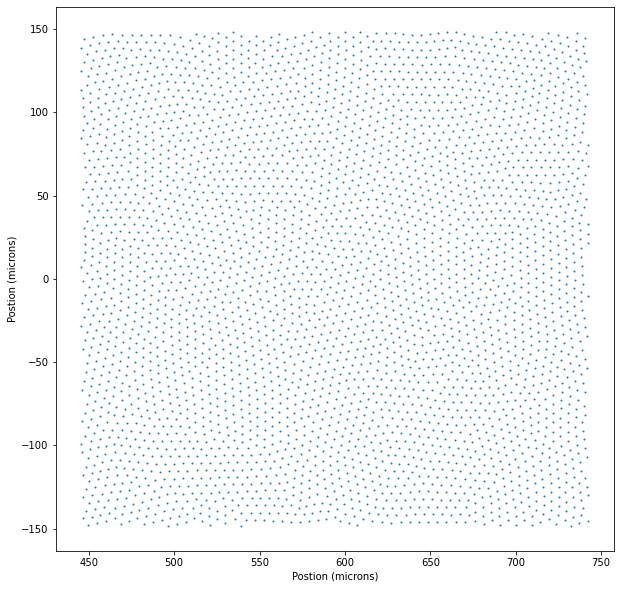

In [47]:
fig_1 = pyplot.figure(1, figsize=(10,10))
ax1_1 = fig_1.add_subplot(111)

ax1_1.scatter(cone_positions_window[0], cone_positions_window[1], s=1)
ax1_1.set_xlabel('Postion (microns)')
ax1_1.set_ylabel('Postion (microns)')

## 3.3 Determine the sizes of the cone cells

The size (standard deviation of the Gaussian intensity profile) of the cells are specified based on their distance from the centre of the fovea using the function generate_retina.coneDiameter, which performs the following calculations:
<br>
<br>
1) Use Equation 4 in Tyler (1985), to specify the diameter of the inner segement, <em>D$_{i}$</em> for a given eccentricity, <em>E</em>:
\begin{equation}
D_{i} = 2.5(E + 0.2)^{1/3}.
\end{equation}
This equation is derived using data from Polyak (1941).
<br>
<br>
2) Determine the $1/e^{2}$ mode field radius, $\omega$, from the inner segment diameter using the Marcuse equation:
\begin{equation}
\frac{\omega}{D_{i}} = 0.65 + \frac{1.619}{V^{3/2}} + \frac{2.879}{V^{6}}.
\end{equation}
The mode number, <em>V</em>, is given by:
\begin{equation}
V = \frac{2\pi D_{i}}{\lambda} \sqrt{n_{core}^{2}-n_{cladding}^{2}},
\end{equation}
where <em> n$_{core}$ </em> is the refractive index of the core of a step-index fibre (taken to be the refractive index of the inner segment, 1.378; Meadway and Sincich, 2019), <em> n$_{cladding}$ </em> is the refractive index of the cladding of a step-index fibre (taken to be the refractive index of the surrounding medium, 1.34;  Meadway and Sincich, 2019) and $\lambda$ is the wavelength of light.
<br>
<br>
3) Convert the $1/e^{2}$ mode field radius to the standard deviation of the Gaussian distribution (divide by two).

Text(0, 0.5, 'Cone size (microns, standard deviation)')

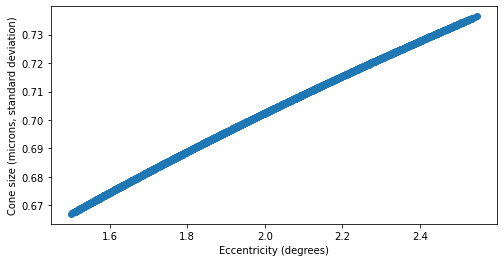

In [49]:
# Calculate the eccentricities of the cells
eccentricities = numpy.sqrt(cone_positions_window[0]**2 + cone_positions_window[1]**2) / myAOSLO.parameters['microns_per_degree']

# Calculate the cone sizes
cone_sizes_window = generate_retina.coneDiameter(eccentricities, myAOSLO.parameters['microns_per_degree'], myAOSLO.parameters['wavelength_m'] )

# Plot
fig_2 = pyplot.figure(2, figsize=(8,4))
ax2_1 = fig_2.add_subplot(111)
ax2_1.scatter(eccentricities, cone_sizes_window)
ax2_1.set_xlabel('Eccentricity (degrees)')
ax2_1.set_ylabel('Cone size (microns, standard deviation)')

## 3.4 Make the retinal parameter array
Now that we have the cone positions and sizes defined, we generate the <span style='background-color:rgb(227,240,218)'>retinal parameter array</span>. This is an (6 x N) array of N cones, each of which has defined: 
<br>
(vertical position, horizontal position, vertical width, horizontal width, rotation angle and reflectance)
<br>
The units are microns and so these values are independent of the pixel size of your AOSLO images. The widths are defined as the standard deviation of the Gaussian reflectance profile. Reflectance values are in the range 0 -> 1. It is possible to specify different horizontal and vertical cone widths (making them elliptical with a given rotation angle), although in practice we normally assume that they are circular, such that vertical width = horizontal width and the rotation angle is arbitrary.

In [50]:
# To make cells that are circular, copy the cone size for both the horizonal and vertical dimensions. The
# following creates a (2, N) array of the vertical and horizontal widths
cone_sizes_window_2d = numpy.repeat(cone_sizes_window[numpy.newaxis,:], 2, axis=0)

retina_window = generate_retina.retina(cone_positions_window,
                                       cone_sizes_window_2d,
                                       reflectance_map=None,
                                       width_variation=cone_reflectance_parameters['width_variation'],
                                       mean_reflectance=cone_reflectance_parameters['normal_mean'],
                                       std_reflectance=cone_reflectance_parameters['normal_std'],
                                       distribution='normal')


We can examine the reflectance values to check they confirm to a normal distribution:

Text(0, 0.5, 'Probability density')

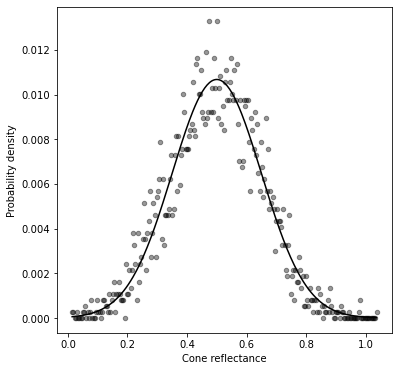

In [51]:
cone_reflectances = retina_window[5]

# Compute the historam
counts, bin_edges = numpy.histogram(cone_reflectances, bins=2**myAOSLO.parameters['bit_depth'])
bin_centres = (bin_edges[1:]-bin_edges[:-1])*0.5 + bin_edges[:-1]

# Plot the histogram (as scatter plot)
fig_3 = pyplot.figure(3, figsize=(6, 6))
ax3_1 = fig_3.add_subplot(111)
ax3_1.scatter(bin_centres, counts / float(len(cone_reflectances)), color='black', label = 'Cone reflectances', s=20, alpha=0.4)

# Plot the distribution
reflectance_distribution = ERICA_toolkit.functGaussian(bin_centres, cone_reflectance_parameters['normal_mean'], cone_reflectance_parameters['normal_std'])
ax3_1.plot(bin_centres, reflectance_distribution / numpy.sum(reflectance_distribution), color='black', label = 'Cone reflectance distribution')

ax3_1.set_xlabel('Cone reflectance')
ax3_1.set_ylabel('Probability density')


### 3.4.1 Wrapper function to do all of the above
The following function will perform the above operations for you to generate a retina parameter array based on the raw reaction diffusion outputs (<span style='background-color:rgb(251,230,215)'>cone locations</span>; unscaled and independent of your AOSLO set up), the <span style='background-color:rgb(199,235,236)'>cone reflectance parameters</span>, the <span style='background-color:rgb(236,236,236)'>eccentricity</span> (in degrees), a specified field of view (to minimise the file size; in degrees) and the AOSLO <span style='background-color:rgb(206,190,218)'>system parameter file</span>:

In [52]:
field_of_view_save = [2.0, 2.0]
retina = generate_retina.generateRetinaFromEccentricity(peaks, 
                                                        eccentricity, 
                                                        field_of_view_save, 
                                                        myAOSLO.parameters['microns_per_degree'], 
                                                        myAOSLO.parameters['wavelength_m'], 
                                                        reflectance_map=None,
                                                        width_variation=cone_reflectance_parameters['width_variation'],
                                                        mean_reflectance=cone_reflectance_parameters['normal_mean'],
                                                        std_reflectance=cone_reflectance_parameters['normal_std'],
                                                        distribution='normal')




We can save this <span style='background-color:rgb(227,240,218)'>retinal mosaic parameter array</span> to file (<span style='background-color:rgb(227,240,218)'>ground_truth_retina_params_eccentricity_Y_02-00_X_00-00.fits</span>; the spatial units are microns and the data are specific to your AOSLO). We also include the retinal eccentricity and whether it was foveated in the file header. Here we use '-' in place of a decimal point for recording the retinal eccentricity in the file name:

In [53]:
file_name_retina_parameter_array = 'ground_truth_retina_params_eccentricity_Y_%02i-%02i_X_%02i-%02i.fits'%(numpy.floor(eccentricity[0]), round((eccentricity[0]-numpy.floor(eccentricity[0]))*10), numpy.floor(eccentricity[1]), round((eccentricity[1]-numpy.floor(eccentricity[1]))*10))
sys.stdout.write('Retina parameter array will be saved as: %s'%file_name_retina_parameter_array)

Retina parameter array will be saved as: ground_truth_retina_params_eccentricity_Y_02-00_X_00-00.fits

101

### A note on FITS files

Here is a good point to demonstrate how fits files work, if you are not already familiar with them. Fits files contain a list of Header Data Units (HDUs). Each HDU object has a header attribute and a data attribute, allowing us to store information alongside the data so that we can check how the data were generated at a later date. The header contains a list of 80-byte 'cards'. Each card contains a keyword and a value. We can treat the header just like a dictionary, although the value cannot be a list or array in this case. The keyword cannot be longer than 8 characters - to overcome this we use a HIERARCH card (this is requested by prepending "HIERARCH" to the begining of the keyword)

In [54]:
# Create a fits header
fits_header = fits.Header()
# Store some information in the header
fits_header['HIERARCH Eccentricity_degrees_Y'] = eccentricity[0]
fits_header['HIERARCH Eccentricity_degrees_X'] = eccentricity[1]
fits_header['HIERARCH FOV_degrees_Y'] = field_of_view_save[0]
fits_header['HIERARCH FOV_degrees_X'] = field_of_view_save[1]
fits_header['HIERARCH Foveated'] = False
fits_header['HIERARCH Mosaic_number'] = mosaic_number
fits_header['HIERARCH Width_variation'] = cone_reflectance_parameters['width_variation']
fits_header['HIERARCH reflectance_mean'] = cone_reflectance_parameters['normal_mean']
fits_header['HIERARCH reflectance_stdev'] = cone_reflectance_parameters['normal_std']
fits_header['HIERARCH reflectance_distribution'] = 'normal'


We will use the primary HDU to store the data and header, and then save it to file:

In [55]:
# Create the primary HDU containing the data (retina) and the header, defined above
hdu = fits.PrimaryHDU(retina, header=fits_header)
# Create the HDU list for this file
hdu_list = fits.HDUList([hdu])
# Save it
hdu_list.writeto(os.path.normpath(os.path.join(save_folder_ground_truth, file_name_retina_parameter_array)), overwrite=True)
sys.stdout.write('Saving retina parameter array to file: %s'%file_name_retina_parameter_array)

Saving retina parameter array to file: ground_truth_retina_params_eccentricity_Y_02-00_X_00-00.fits

99

To look at the contents:

In [56]:
#  Open the fits file
fits_file_contents = fits.open(os.path.normpath(os.path.join(save_folder_ground_truth, file_name_retina_parameter_array)))
# Look at the primary HDU (index 0)
retinal_parameters_from_file = fits_file_contents[0]
# Look at the contents of the header, e.g. the horizontal retinal eccentricity
sys.stdout.write('Nasal/temporal (horizontal) eccentricity: %.2f degrees \n'%retinal_parameters_from_file.header['Eccentricity_degrees_X'])
# Or e.g. the type of distribution used for selection of cone reflectance values
sys.stdout.write('Cone reflectance distribution: %s'%retinal_parameters_from_file.header['reflectance_distribution'])



Nasal/temporal (horizontal) eccentricity: 0.00 degrees 
Cone reflectance distribution: normal

37

Now we have generated a retinal parameter array and saved it to file, let's take a quick look at the ground truth retina. For a quick check, we just assume linear sampling of the image (i.e. not accounting for the sinusoidal horizontal scanner):

Text(0.5, 1.0, 'Ground truth retina (no diffraction)')

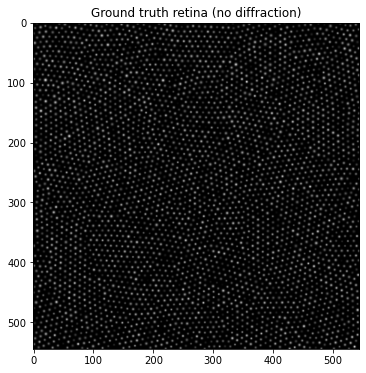

In [57]:
image, ground_truth_array = sampling.quickLookImage(retina_window, eccentricity, field_of_view, myAOSLO.parameters['microns_per_degree'], myAOSLO.parameters['pixel_size_arcmin_y_x'])

fig_4 = pyplot.figure(4, figsize=(6,6))
ax4_1 = fig_4.add_subplot(111)
ax4_1.imshow(image, cmap='gray')
ax4_1.set_title('Ground truth retina (no diffraction)')

We can also add the effect of diffraction to show what the ground truth image would look like:

Text(0.5, 1.0, 'Ground truth retina (with diffraction)')

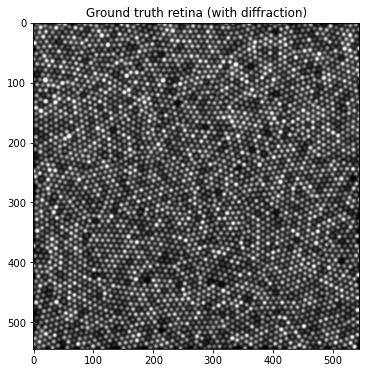

In [58]:
image_diffraction = frame_generation.diffractionOnly(image, myAOSLO.parameters['pixel_size_arcmin_y_x'], myAOSLO.parameters['wavelength_m'], myAOSLO.parameters['pupil_diameter_m'], myAOSLO.parameters['pinhole_diameter_Airy_radii'])

# Add the effect of saturation
saturation_value = numpy.percentile(image_diffraction, (1.0-myAOSLO.parameters['proportion_saturated_pixels'])*100)
image_diffraction_clipped = numpy.clip(image_diffraction, 0.0, saturation_value)

fig_5 = pyplot.figure(5, figsize=(6,6))
ax5_1 = fig_5.add_subplot(111)
ax5_1.imshow(image_diffraction_clipped, cmap='gray')    
ax5_1.set_title('Ground truth retina (with diffraction)')

Now we can check the groundtruth locations match up (we'll zoom in to see more clearly):

(0.0, 50.0, 0.0, 50.0)

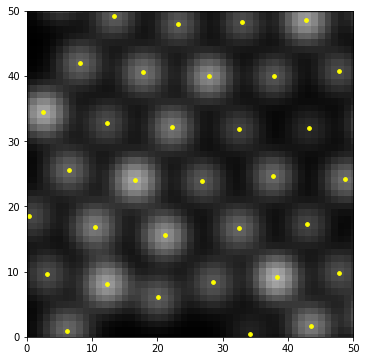

In [59]:
fig_6 = pyplot.figure(6, figsize=(6,6))
ax6_1 = fig_6.add_subplot(111)
ax6_1.imshow(image_diffraction, cmap='gray')
ax6_1.scatter(ground_truth_array[1],ground_truth_array[0], color='yellow', s=14)

# Limit the axes to see the cones and ground truth markers more easily
pyplot.axis([0,50,0,50])

## 3.2 Generate a foveated mosaic of cone cells
It is possible to scale the positions of the cones to create a fovea.

First we take the pre-generated mosaic of spots (<span style='background-color:rgb(251,230,215)'>cone locations</span>) and then 'foveate' the points to match histological data, and we also reposition the fovea so that it is centred on the point of highest cell density. This can take a little time as we are using a large range of eccentricities. In practice we normally use cone positions from a pre-generated foveated retina.

In [60]:
foveated_points = generate_retina.foveatePoints(peaks, myAOSLO.parameters['microns_per_degree'])
cone_positions_foveated = generate_retina.centreFovea(foveated_points)

We can plot the spacings to check they match histology:

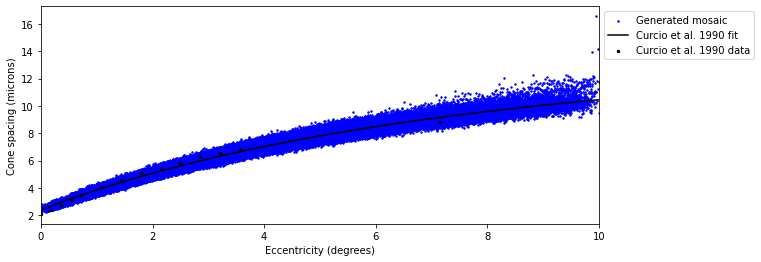

In [61]:
fig_7 = plotSpacing(cone_positions_foveated, myAOSLO.parameters['microns_per_degree'])

For the foveated mosaic, we'll use an <span style='background-color:rgb(236,236,236)'>eccentricity</span> of (0.0, 0.0), to see the centre of the fovea:

In [62]:
eccentricity_foveated = [0.0,0.0]

# Select a 1 deg field of view for display
field_of_view_foveated = [1.0,1.0]
cone_indices_window = numpy.where(
    (cone_positions_foveated[0] > (eccentricity_foveated[0] - 0.5 * field_of_view_foveated[0]) * myAOSLO.parameters['microns_per_degree']) 
    & (cone_positions_foveated[0] < (eccentricity_foveated[0] + 0.5 * field_of_view_foveated[0]) * myAOSLO.parameters['microns_per_degree']) 
    & (cone_positions_foveated[1] > (eccentricity_foveated[1] - 0.5 * field_of_view_foveated[1]) * myAOSLO.parameters['microns_per_degree']) 
    & (cone_positions_foveated[1] < (eccentricity_foveated[1] + 0.5 * field_of_view_foveated[1]) * myAOSLO.parameters['microns_per_degree']))[0]
cone_positions_foveated_window = cone_positions_foveated[:,cone_indices_window]


We can also show a scatter plot of the cone positions (within a small window, so we can see them more clearly):

Text(0, 0.5, 'Position (microns)')

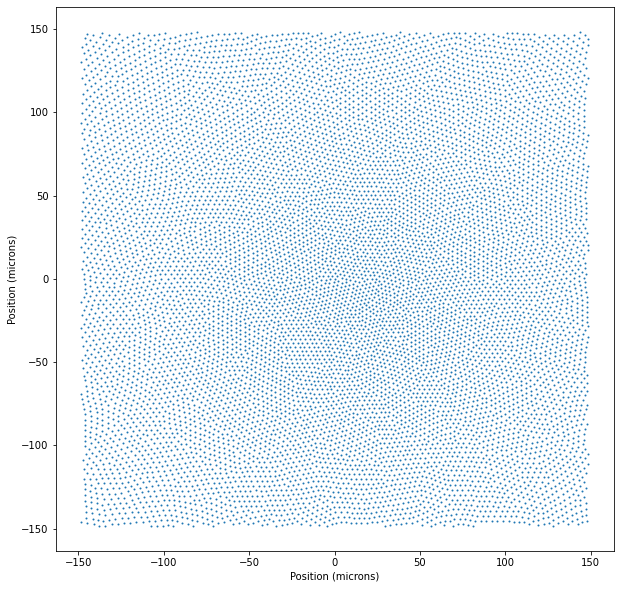

In [63]:
fig_8 = pyplot.figure(8, figsize=(10,10))
ax8_1 = fig_8.add_subplot(111)
ax8_1.scatter(cone_positions_foveated_window[1], cone_positions_foveated_window[0], s=1)
ax8_1.set_xlabel('Position (microns)')
ax8_1.set_ylabel('Position (microns)')

Next we calculate the cone sizes, as we did before:

In [64]:
# Calculate the eccentricities of the cones
eccentricities_foveated = numpy.sqrt(cone_positions_foveated[0]**2 + cone_positions_foveated[1]**2) / myAOSLO.parameters['microns_per_degree']

# Calculate the cone sizes (standard deviation of Gaussian intensity profile)
cone_size_foveated = generate_retina.coneDiameter(eccentricities_foveated, myAOSLO.parameters['microns_per_degree'], myAOSLO.parameters['wavelength_m'])


We can then plot the cone sizes as a function of their eccentricity, as derived above. It should be noted that mode field diameter of an optical fiber decreases with the diameter of the fiber core, but below a certain value the mode field diameter begins to increase again. This is not consistent with what we observe (to the best of our knowledge, given the resolution limits of most AOSLOs) and so for low eccentricities we set the cone sizes to the minimum value. This is an approximation; if you prefer you could replace the cone diameters with your own values.

Text(0, 0.5, 'Standard deviation of cone \n Gaussian intensity profile (microns)')

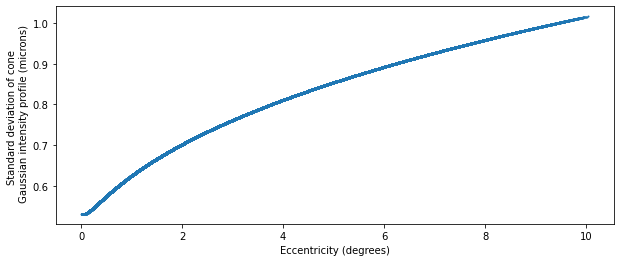

In [67]:
fig_9 = pyplot.figure(9, figsize=(10,4))
ax9_1 = fig_9.add_subplot(111)
ax9_1.scatter(eccentricities_foveated, cone_size_foveated, s=1)
ax9_1.set_xlabel('Eccentricity (degrees)')
ax9_1.set_ylabel('Standard deviation of cone \n Gaussian intensity profile (microns)')


As before, we set the horizontal and vertical cone widths to be the same, and then generate a retinal mosaic parameter array:

In [68]:
cone_sizes_foveated = numpy.repeat(cone_size_foveated[numpy.newaxis,:], 2, axis=0)

retina_foveated = generate_retina.retina(cone_positions_foveated,
                                         cone_sizes_foveated, 
                                         reflectance_map=None,
                                         width_variation=cone_reflectance_parameters['width_variation'],
                                         mean_reflectance=cone_reflectance_parameters['normal_mean'],
                                         std_reflectance=cone_reflectance_parameters['normal_std'],
                                         distribution='normal')


Again, we save the <span style='background-color:rgb(227,240,218)'>retinal mosaic parameter array</span> to file (<span style='background-color:rgb(227,240,218)'>ground_truth_retina_params_fovea.fits</span>). In this case we are going to save all of the cones across the full range of eccentricities, so this file could be used to generate images from a range of eccentricities:

In [69]:
file_name = 'ground_truth_retina_params_fovea.fits'

# Create a fits header
fits_header = fits.Header()

# Store some information in the header
fits_header['HIERARCH Eccentricity_degrees_Y'] = 0.0
fits_header['HIERARCH Eccentricity_degrees_X'] = 0.0
fits_header['HIERARCH Foveated'] = True
fits_header['HIERARCH Mosaic_number'] = mosaic_number
fits_header['HIERARCH width_variation'] = cone_reflectance_parameters['width_variation']
fits_header['HIERARCH reflectance_mean'] = cone_reflectance_parameters['normal_mean']
fits_header['HIERARCH reflectance_stdev'] = cone_reflectance_parameters['normal_std']
fits_header['HIERARCH reflectance_distribution'] = 'normal'

# Create the primary HDU containing the data (retina_foveated) and the header, defined above
hdu = fits.PrimaryHDU(retina_foveated, header=fits_header)

# Create the HDU list for this file
hdu_list = fits.HDUList([hdu])

# Save it
hdu_list.writeto(os.path.normpath(os.path.join(save_folder_ground_truth, file_name)), overwrite=True)
sys.stdout.write('Saving retinal parameter array to file: %s'%file_name)

Saving retinal parameter array to file: ground_truth_retina_params_fovea.fits

77

As above, we can take a quick look at the image. For speed we'll use the windowed version, with the reduced field of view:

In [70]:
retina_foveated_window = retina_foveated[:,cone_indices_window]
image_foveated, ground_truth_foveated = sampling.quickLookImage(retina_foveated_window, eccentricity_foveated, field_of_view_foveated, myAOSLO.parameters['microns_per_degree'], myAOSLO.parameters['pixel_size_arcmin_y_x'])


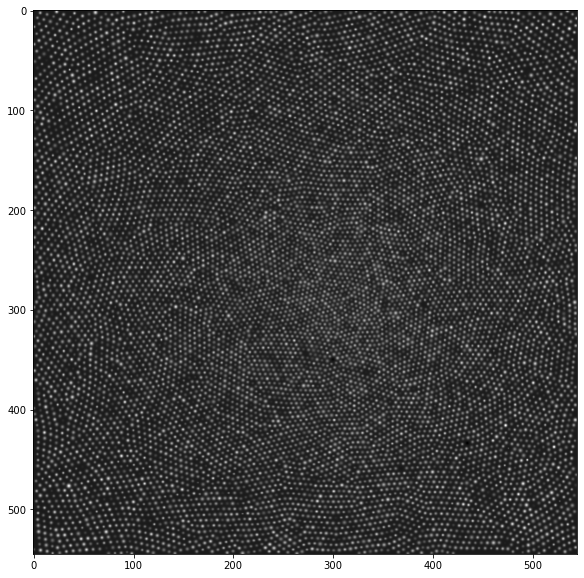

In [71]:
fig_10 = pyplot.figure(10, figsize=(10,10))
ax10_1 = fig_10.add_subplot(111)
ax10_1.imshow(image_foveated, cmap='gray')

Finally we can add diffraction effects (based on the demo system, which has a long wavelength and a small pupil):

In [72]:
image_foveated_diffraction = frame_generation.diffractionOnly(image_foveated, myAOSLO.parameters['pixel_size_arcmin_y_x'], myAOSLO.parameters['wavelength_m'], myAOSLO.parameters['pupil_diameter_m'], myAOSLO.parameters['pinhole_diameter_Airy_radii'])


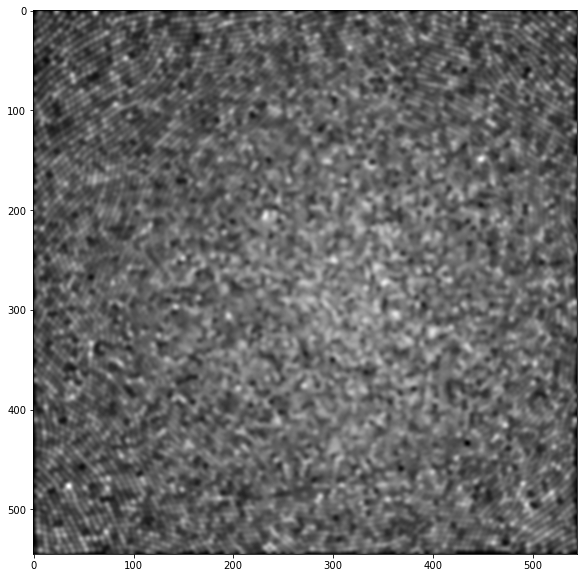

In [73]:
fig_11 = pyplot.figure(11, figsize=(10,10))

ax11_1 = fig_11.add_subplot(111)
ax11_1.imshow(image_foveated_diffraction, cmap='gray')

Let's repeat it with a larger pupil diameter - 8.0 mm:

In [76]:
pupil_diameter = 8.0e-3
image_foveated_diffraction_larger_pupil = frame_generation.diffractionOnly(image_foveated, myAOSLO.parameters['pixel_size_arcmin_y_x'], myAOSLO.parameters['wavelength_m'], pupil_diameter, myAOSLO.parameters['pinhole_diameter_Airy_radii'])


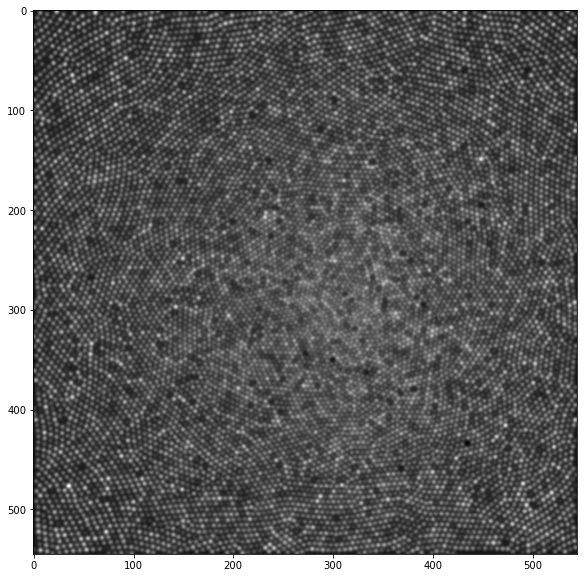

In [77]:
fig_12 = pyplot.figure(12, figsize=(10,10))

ax12_1 = fig_12.add_subplot(111)
ax12_1.imshow(image_foveated_diffraction_larger_pupil, cmap='gray')

We can consider this the ground truth image, it is the instrument should see if the scanning were linear and there were no eye moveemnts, noise or residual aberrations.